In [126]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from surprise import SVD
import warnings
warnings.filterwarnings('ignore')

**About Book Crossing Dataset**<br>

This dataset has been compiled by Cai-Nicolas Ziegler in 2004, and it comprises of three tables for users, books and ratings. Explicit ratings are expressed on a scale from 1-10 (higher values denoting higher appreciation) and implicit rating is expressed by 0.

Reference: http://www2.informatik.uni-freiburg.de/~cziegler/BX/ 

**Objective**

This project entails building a Book Recommender System for users based on user-based and item-based collaborative filtering approaches.

#### Execute the below cell to load the datasets

In [140]:
#Loading data
books = pd.read_csv("books.csv", sep=";", error_bad_lines=False, encoding="latin-1")
books.columns = ['ISBN', 'bookTitle', 'bookAuthor', 'yearOfPublication', 'publisher', 'imageUrlS', 'imageUrlM', 'imageUrlL']

users = pd.read_csv('users.csv', sep=';', error_bad_lines=False, encoding="latin-1")
users.columns = ['userID', 'Location', 'Age']

ratings = pd.read_csv('ratings.csv', sep=';', error_bad_lines=False, encoding="latin-1")
ratings.columns = ['userID', 'ISBN', 'bookRating']

b'Skipping line 6452: expected 8 fields, saw 9\nSkipping line 43667: expected 8 fields, saw 10\nSkipping line 51751: expected 8 fields, saw 9\n'
b'Skipping line 92038: expected 8 fields, saw 9\nSkipping line 104319: expected 8 fields, saw 9\nSkipping line 121768: expected 8 fields, saw 9\n'
b'Skipping line 144058: expected 8 fields, saw 9\nSkipping line 150789: expected 8 fields, saw 9\nSkipping line 157128: expected 8 fields, saw 9\nSkipping line 180189: expected 8 fields, saw 9\nSkipping line 185738: expected 8 fields, saw 9\n'
b'Skipping line 209388: expected 8 fields, saw 9\nSkipping line 220626: expected 8 fields, saw 9\nSkipping line 227933: expected 8 fields, saw 11\nSkipping line 228957: expected 8 fields, saw 10\nSkipping line 245933: expected 8 fields, saw 9\nSkipping line 251296: expected 8 fields, saw 9\nSkipping line 259941: expected 8 fields, saw 9\nSkipping line 261529: expected 8 fields, saw 9\n'


### Check no.of records and features given in each dataset

In [142]:
numOfRows = books.shape[0]
numOfColumns = books.shape[1]
print('Number of Rows in books dataframe : {:,}'.format(numOfRows))
print('Number of Columns in books dataframe : ' , numOfColumns)
books.info()

Number of Rows in books dataframe : 271,360
Number of Columns in books dataframe :  8
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
ISBN                 271360 non-null object
bookTitle            271360 non-null object
bookAuthor           271359 non-null object
yearOfPublication    271360 non-null object
publisher            271358 non-null object
imageUrlS            271360 non-null object
imageUrlM            271360 non-null object
imageUrlL            271357 non-null object
dtypes: object(8)
memory usage: 16.6+ MB


In [143]:
numOfRows = users.shape[0]
numOfColumns = users.shape[1]
print('Number of Rows in users dataframe : {:,}'.format(numOfRows))
print('Number of Columns in users dataframe : ' , numOfColumns)
users.info()

Number of Rows in users dataframe : 278,858
Number of Columns in users dataframe :  3
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
userID      278858 non-null int64
Location    278858 non-null object
Age         168096 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.4+ MB


In [144]:
numOfRows = ratings.shape[0]
numOfColumns = ratings.shape[1]
print('Number of Rows in ratings dataframe : {:,}'.format(numOfRows))
print('Number of Columns in ratings dataframe : ' , numOfColumns)
ratings.info()

Number of Rows in ratings dataframe : 1,149,780
Number of Columns in ratings dataframe :  3
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
userID        1149780 non-null int64
ISBN          1149780 non-null object
bookRating    1149780 non-null int64
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


## Exploring books dataset

In [145]:
books.head()

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher,imageUrlS,imageUrlM,imageUrlL
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


### Drop last three columns containing image URLs which will not be required for analysis

In [146]:
books.drop(['imageUrlS','imageUrlM','imageUrlL'], axis=1, inplace=True)

In [147]:
books.head()

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company


**yearOfPublication**

### Check unique values of yearOfPublication


In [148]:
books["yearOfPublication"].unique()

array([2002, 2001, 1991, 1999, 2000, 1993, 1996, 1988, 2004, 1998, 1994,
       2003, 1997, 1983, 1979, 1995, 1982, 1985, 1992, 1986, 1978, 1980,
       1952, 1987, 1990, 1981, 1989, 1984, 0, 1968, 1961, 1958, 1974,
       1976, 1971, 1977, 1975, 1965, 1941, 1970, 1962, 1973, 1972, 1960,
       1966, 1920, 1956, 1959, 1953, 1951, 1942, 1963, 1964, 1969, 1954,
       1950, 1967, 2005, 1957, 1940, 1937, 1955, 1946, 1936, 1930, 2011,
       1925, 1948, 1943, 1947, 1945, 1923, 2020, 1939, 1926, 1938, 2030,
       1911, 1904, 1949, 1932, 1928, 1929, 1927, 1931, 1914, 2050, 1934,
       1910, 1933, 1902, 1924, 1921, 1900, 2038, 2026, 1944, 1917, 1901,
       2010, 1908, 1906, 1935, 1806, 2021, '2000', '1995', '1999', '2004',
       '2003', '1990', '1994', '1986', '1989', '2002', '1981', '1993',
       '1983', '1982', '1976', '1991', '1977', '1998', '1992', '1996',
       '0', '1997', '2001', '1974', '1968', '1987', '1984', '1988',
       '1963', '1956', '1970', '1985', '1978', '1973', '1980'

As it can be seen from above that there are some incorrect entries in this field. It looks like Publisher names 'DK Publishing Inc' and 'Gallimard' have been incorrectly loaded as yearOfPublication in dataset due to some errors in csv file.


Also some of the entries are strings and same years have been entered as numbers in some places. We will try to fix these things in the coming questions.

### Check the rows having 'DK Publishing Inc' as yearOfPublication

In [149]:
books.loc[books["yearOfPublication"] == 'DK Publishing Inc']

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
209538,078946697X,"DK Readers: Creating the X-Men, How It All Beg...",2000,DK Publishing Inc,http://images.amazon.com/images/P/078946697X.0...
221678,0789466953,"DK Readers: Creating the X-Men, How Comic Book...",2000,DK Publishing Inc,http://images.amazon.com/images/P/0789466953.0...


### Drop the rows having `'DK Publishing Inc'` and `'Gallimard'` as `yearOfPublication`

In [150]:
books[(books["yearOfPublication"]=='DK Publishing Inc') | (books["yearOfPublication"]=='Gallimard')]

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
209538,078946697X,"DK Readers: Creating the X-Men, How It All Beg...",2000,DK Publishing Inc,http://images.amazon.com/images/P/078946697X.0...
220731,2070426769,"Peuple du ciel, suivi de 'Les Bergers\"";Jean-M...",2003,Gallimard,http://images.amazon.com/images/P/2070426769.0...
221678,0789466953,"DK Readers: Creating the X-Men, How Comic Book...",2000,DK Publishing Inc,http://images.amazon.com/images/P/0789466953.0...


In [151]:
indexNames = books[(books["yearOfPublication"]=='DK Publishing Inc') | (books["yearOfPublication"]=='Gallimard')].index
books.drop(indexNames , inplace=True)
books[(books["yearOfPublication"]=='DK Publishing Inc') | (books["yearOfPublication"]=='Gallimard')].count()

ISBN                 0
bookTitle            0
bookAuthor           0
yearOfPublication    0
publisher            0
dtype: int64

### Change the datatype of yearOfPublication to 'int'

In [152]:
books = books.astype({"yearOfPublication": int})

In [153]:
books.dtypes

ISBN                 object
bookTitle            object
bookAuthor           object
yearOfPublication     int32
publisher            object
dtype: object

### Drop NaNs in `'publisher'` column


In [154]:
print("NaN's before deletion : ",books[books['publisher'].isnull()]['publisher'].shape[0])
books.dropna(subset=['publisher'],axis=0,inplace=True)
print("NaN's after deletion : ",books[books['publisher'].isnull()]['publisher'].shape[0])

NaN's before deletion :  2
NaN's after deletion :  0


## Exploring Users dataset

In [155]:
users.head()

,userID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


### Get all unique values in ascending order for column `Age`

In [156]:
print(sorted(users['Age'].unique()))

[nan, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0, 101.0, 102.0, 103.0, 104.0, 105.0, 106.0, 107.0, 108.0, 109.0, 110.0, 111.0, 113.0, 114.0, 115.0, 116.0, 118.0, 119.0, 123.0, 124.0, 127.0, 128.0, 132.0, 133.0, 136.0, 137.0, 138.0, 140.0, 141.0, 143.0, 146.0, 147.0, 148.0, 151.0, 152.0, 156.0, 157.0, 159.0, 162.0, 168.0, 172.0, 175.0, 183.0, 186.0, 189.0, 199.0, 200.0, 201.0, 204.0, 207.0, 208.0, 209.0, 210.0, 212.0, 219.0, 220.0, 223.0, 226.0

Age column has some invalid entries like nan, 0 and very high values like 100 and above

### Values below 5 and above 90 do not make much sense for our book rating case...hence replace these by NaNs

In [157]:
users.loc[(users["Age"] < 5) | (users["Age"] > 90),"Age"] = np.nan

### Replace null values in column `Age` with mean

In [158]:
users["Age"].fillna(round(users["Age"].mean()), inplace=True)

### Change the datatype of `Age` to `int`

In [159]:
users["Age"] = users["Age"].astype(int)

## Exploring the Ratings Dataset

### check the shape

In [160]:
ratings.shape

(1149780, 3)

In [161]:
n_users = users.shape[0]
n_books = books.shape[0]

In [162]:
ratings.head(5)

,userID,ISBN,bookRating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


### Ratings dataset should have books only which exist in our books dataset. Drop the remaining rows

In [166]:
ratings_new = ratings[ratings['ISBN'].isin(books["ISBN"])]

### Ratings dataset should have ratings from users which exist in users dataset. Drop the remaining rows

In [167]:
ratings_new = ratings_new[ratings_new['userID'].isin(users["userID"])]
print(ratings.shape)
print(ratings_new.shape)

(1149780, 3)
(1031130, 3)


### Consider only ratings from 1-10 and leave 0s in column `bookRating`

In [168]:
ratings_new = ratings_new[ratings_new['bookRating']!=0]
ratings_new.shape

(383839, 3)

### Find out which rating has been given highest number of times

In [169]:
ratings_new['bookRating'].value_counts().idxmax()

8

<function matplotlib.pyplot.show(*args, **kw)>

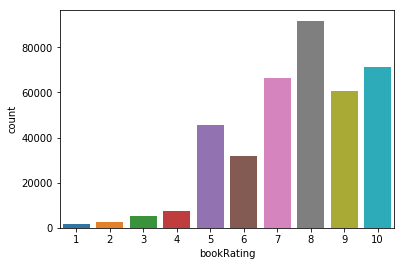

In [170]:
sns.countplot(data=ratings_new,x='bookRating')
plt.show
# A countplot of bookRating indicates that higher ratings are more common amongst users and rating 8 has been rated 
# highest number of times

### **Collaborative Filtering Based Recommendation Systems**

### For more accurate results only consider users who have rated atleast 100 books

In [171]:
counts1 = ratings_new['userID'].value_counts()
ratings_new = ratings_new[ratings_new['userID'].isin(counts1[counts1 >= 100].index)]
counts = ratings_new['bookRating'].value_counts()
ratings_new = ratings_new[ratings_new['bookRating'].isin(counts[counts >= 100].index)]
ratings_new.shape

(103269, 3)

### Generating ratings matrix from explicit ratings


#### Note: since NaNs cannot be handled by training algorithms, replace these by 0, which indicates absence of ratings

In [176]:
ratings_matrix_df = ratings_new.pivot(index='userID',columns='ISBN',values='bookRating')
userID = ratings_matrix_df.index
ISBN = ratings_matrix_df.columns
ratings_matrix_df.fillna(0, inplace = True)
ratings_matrix_df = ratings_matrix_df.astype(np.int32)
ratings_matrix_df.head()
ratings_matrix = ratings_matrix_df.as_matrix()

### Generate the predicted ratings using SVD with no.of singular values to be 50

In [187]:
user_ratings_mean = np.mean(ratings_matrix, axis = 1)
ratings_demeaned = ratings_matrix - user_ratings_mean.reshape(-1, 1)
from scipy.sparse.linalg import svds
U, sigma, Vt = svds(ratings_demeaned, k = 50)
sigma = np.diag(sigma)
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.reshape(-1, 1)
preds_df = pd.DataFrame(all_user_predicted_ratings, index = ratings_matrix_df.index, columns = ratings_matrix_df.columns)
preds_df.head()

ISBN,0000913154,0001046438,000104687X,0001047213,0001047973,000104799X,0001048082,0001053736,0001053744,0001055607,...,B000092Q0A,B00009EF82,B00009NDAN,B0000DYXID,B0000T6KHI,B0000VZEJQ,B0000X8HIE,B00013AX9E,B0001I1KOG,B000234N3A
userID,,,,,,,,,,,,,,,,,,,,,
2033,0.026782,-0.002117,-0.000493,-0.002117,-0.002117,0.004030,-0.001473,0.006066,0.006066,0.012757,...,-0.000761,-0.002984,0.045408,-0.015242,-0.078286,0.004830,0.030557,0.000411,-0.006341,0.069061
2110,-0.007081,-0.003520,0.002556,-0.003520,-0.003520,0.015170,0.000451,-0.002330,-0.002330,0.014413,...,0.014090,0.014776,0.019194,0.004510,-0.019647,0.014777,0.015427,0.014296,0.014224,-0.007096
2276,-0.010854,-0.016486,-0.002251,-0.016486,-0.016486,0.032315,-0.017119,0.011673,0.011673,0.034113,...,0.025330,0.027419,0.067758,0.012525,0.133598,0.031094,0.025940,0.025626,0.034242,-0.048261
4017,-0.020304,0.035857,0.023889,0.035857,0.035857,0.028706,0.028975,-0.000805,-0.000805,0.066419,...,-0.000948,0.002945,0.087435,-0.008658,0.015234,0.025709,-0.000298,-0.000648,0.023094,-0.045901
4385,0.011244,-0.011626,0.012090,-0.011626,-0.011626,0.060196,-0.013531,-0.011274,-0.011274,0.050544,...,0.065934,0.069227,0.037958,0.030262,0.711175,0.058916,0.041851,0.063797,0.071857,0.070338


### Take a particular user_id

### Lets find the recommendations for user with id `2110`

#### Note: Execute the below cells to get the variables loaded

In [83]:
userID = 2110

In [84]:
user_id = 2 #2nd row in ratings matrix and predicted matrix

### Get the predicted ratings for userID `2110` and sort them in descending order

In [188]:
sorted_user_predictions = preds_df.loc[2110].sort_values(ascending=False)
sorted_user_predictions.head()

ISBN
059035342X    0.536383
0345384911    0.293114
0451151259    0.278100
0380759497    0.257534
0345370775    0.255887
Name: 2110, dtype: float64

### Create a dataframe with name `user_data` containing userID `2110` explicitly interacted books

In [189]:
user_data = pd.DataFrame(ratings_new[ratings_new["userID"]==2110])
user_data.head()

,userID,ISBN,bookRating
14448,2110,0060987529,7
14449,2110,0064472779,8
14450,2110,0140022651,10
14452,2110,0142302163,8
14453,2110,0151008116,5


In [190]:
user_data.shape

(103, 3)

### Combine the user_data and and corresponding book data(`book_data`) in a single dataframe with name `user_full_info`

In [191]:
book_data = books[books["ISBN"].isin(user_data["ISBN"])]

In [192]:
book_data.shape

(103, 5)

In [193]:
book_data.head()

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
246,0151008116,Life of Pi,Yann Martel,2002,Harcourt
904,015216250X,So You Want to Be a Wizard: The First Book in ...,Diane Duane,2001,Magic Carpet Books
1000,0064472779,All-American Girl,Meg Cabot,2003,HarperTrophy
1302,0345307674,Return of the Jedi (Star Wars),James Kahn,1983,Del Rey Books
1472,0671527215,Hitchhikers's Guide to the Galaxy,Douglas Adams,1984,Pocket


In [194]:
user_full_info = pd.merge(user_data,book_data,on='ISBN')

In [195]:
user_full_info.head()

,userID,ISBN,bookRating,bookTitle,bookAuthor,yearOfPublication,publisher
0,2110,0060987529,7,Confessions of an Ugly Stepsister : A Novel,Gregory Maguire,2000,Regan Books
1,2110,0064472779,8,All-American Girl,Meg Cabot,2003,HarperTrophy
2,2110,0140022651,10,Journey to the Center of the Earth,Jules Verne,1965,Penguin Books
3,2110,0142302163,8,The Ghost Sitter,Peni R. Griffin,2002,Puffin Books
4,2110,0151008116,5,Life of Pi,Yann Martel,2002,Harcourt


### Get top 10 recommendations for above given userID from the books not already rated by that user

In [196]:
recom = (books[~books['ISBN'].isin(user_full_info['ISBN'])].
                            merge(pd.DataFrame(sorted_user_predictions).reset_index(), how = 'left',
                                  left_on = 'ISBN',
                                  right_on = 'ISBN'))
recom = recom.rename(columns = {2110 : 'Predictions'})
recommend = recom.sort_values(by=['Predictions'], ascending = False)
recommendations = recommend.iloc[:10, :-1]
recommendations

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
6184,0345384911,Crystal Line,Anne McCaffrey,1993,Del Rey Books
2031,0451151259,Eyes of the Dragon,Stephen King,1988,Penguin Putnam~mass
976,0380759497,Xanth 15: The Color of Her Panties,Piers Anthony,1992,Eos
1192,0345370775,Jurassic Park,Michael Crichton,1999,Ballantine Books
455,044021145X,The Firm,John Grisham,1992,Bantam Dell Publishing Group
54653,0880389117,Flint the King (Dragonlance: Preludes),Mary Kirchoff,1990,Wizards of the Coast
2435,0345353145,Sphere,MICHAEL CRICHTON,1988,Ballantine Books
81942,0441845630,Unicorn Point (Apprentice Adept (Paperback)),Piers Anthony,1990,ACE Charter
95008,1560768304,"The Dragons of Krynn (Dragonlance Dragons, Vol...",Margaret Weis,1994,Wizards of the Coast
3413,0439064872,Harry Potter and the Chamber of Secrets (Book 2),J. K. Rowling,2000,Scholastic
